# Convolutional Neural Network on Fashion MNIST
---
Don't forget to use **https://pytorch.org/docs/stable/**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Application of convolutional filters to image

In [9]:
from image_processing_workshop.utils import get_image_from_url
from image_processing_workshop.visual import plot_image
import matplotlib.pylab as plt
import numpy as np
import torch

### Download your favouirite image

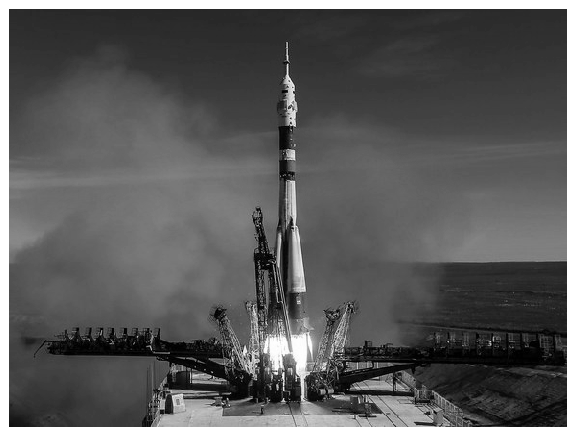

In [21]:
url = 'https://media.wired.com/photos/5bbf72c46278de2d2123485b/master/w_582,c_limit/soyuz-1051882240.jpg'
img = get_image_from_url(url, to_grayscale=True)
plot_image(img, is_grayscale=True)

### Explore prepared filters

In [22]:
initial_filter = np.array([[-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1]])
filter_1 = initial_filter
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

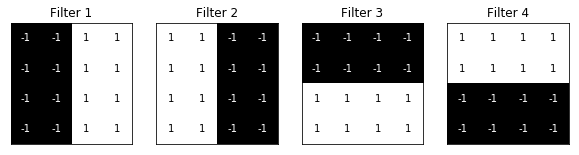

In [23]:
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    
    # Add -1 1 annotations to image.
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

### Build small network initialised with those filters

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
filters_torch = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
filters_torch.shape

torch.Size([4, 1, 4, 4])

In [26]:
img_torch = torch.from_numpy(img).unsqueeze(0).unsqueeze(1)
img_torch.shape

torch.Size([1, 1, 436, 582])

In [28]:
class ConvNeuralNetSimple(nn.Module):    
    def __init__(self, filters):
        super(ConvNeuralNetSimple, self).__init__()
        
        height, width = filters.shape[2:]
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(height, width), bias=False)
        self.conv_layer.weight.data = filters

    def forward(self, images):
        return self.conv_layer(images)
    
conv_neural_net_simple = ConvNeuralNetSimple(filters_torch)
print(conv_neural_net_simple)
print(list(conv_neural_net_simple.parameters()))

ConvNeuralNet(
  (conv_layer): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
[Parameter containing:
tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]], requires_grad=True)]


### Visualize conv layer fature maps

In [19]:
def vizualize_feature_maps(feature_maps, n_maps= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_maps):
        ax = fig.add_subplot(1, n_maps, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(feature_maps[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

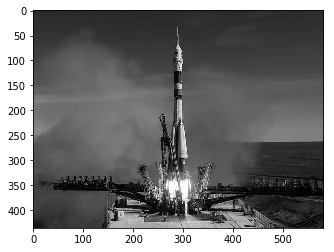

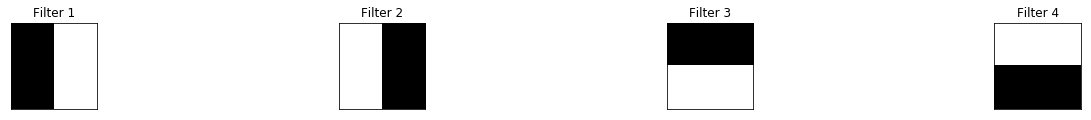

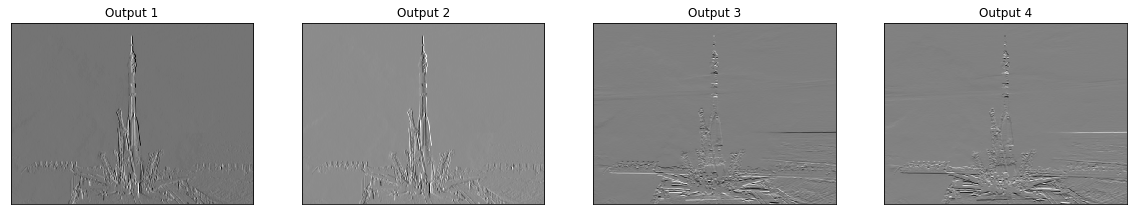

In [29]:
# Source img.
plt.imshow(img, cmap='gray')

# Convolution filters.
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

# Feature maps.    
feature_maps = conv_neural_net_simple(img_torch)
vizualize_feature_maps(feature_maps)

### Sensitivity of image on convolution filters

In [30]:
from ipywidgets import interactive
import ipywidgets as ipw

In [31]:
feature_maps.shape

torch.Size([1, 4, 433, 579])

In [44]:
feature_map = feature_maps[0][0].detach().numpy()
feature_map.shape

(433, 579)

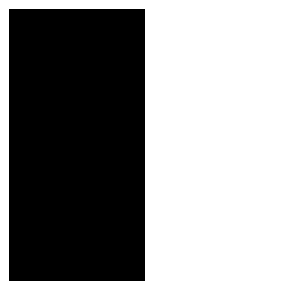

In [52]:
plot_image(filter_1, is_grayscale=True, figsize=(5, 5))

In [43]:
feature_map_max = feature_map.max()
def plot_sensitivity(tolerance):
    feature_map_filtered = (feature_map >= (feature_map_max - tolerance)).astype(int)
    fig = plt.figure(figsize=(10, 10))
    im = plt.imshow(feature_map_filtered, cmap='gray')
    plt.colorbar(im, orientation='horizontal')
    plt.gca().axes.set_axis_off()
    plt.show()
    
interactive(plot_sensitivity, tolerance=ipw.FloatSlider(0.5, min=0, max=feature_map_max - 0.1, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='tolerance', max=5.456862354278565, step=0.01), Outpu…

## Building Model

In [46]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader

### Prepare spatial data

In [47]:
transformations = Compose([ToTensor()])
train_dataset = FashionMNIST('fm_data/', download=True, train=True, transform=transformations, target_transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = FashionMNIST('fm_data/', download=True, train=False, transform=transformations, target_transform=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### Define neural network

In [ ]:
from torch.nn import Module
from torch.nn import ReLU, Tanh, Dropout, Softmax, Linear, Conv2d, MaxPool2d
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.init import xavier_uniform_, normal_

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        self.conv1_output = x
        x = self.pool(F.relu(self.conv2(x)))
        self.conv2_output = x

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)